In [15]:
from typing import Annotated, Dict, Any, List
from langchain_core.messages import HumanMessage, AIMessage
from langchain_experimental.agents import create_pandas_dataframe_agent
from langchain_openai import ChatOpenAI
import pandas as pd

def PandasAgent(state: Dict[str, Any]) -> Dict[str, Any]:
    """
    A Pandas agent that can analyze and manipulate DataFrames based on natural language queries.
    
    Args:
        state (Dict[str, Any]): Current state containing messages and DataFrame
            Expected keys:
            - "messages": List of conversation messages
            - "df": pandas DataFrame to analyze
            
    Returns:
        Dict[str, Any]: Updated state with analysis results
    """
    
    # Extract the latest message and DataFrame from state
    messages = state.get("messages", [])
    df = state.get("df")
    
    if df is None:
        return {
            "messages": messages + [
                AIMessage(content="Error: No DataFrame found in state")
            ]
        }
    
    # Get the latest query from messages
    latest_message = messages[-1].content if messages else ""
    
    try:
        # Create pandas agent
        agent = create_pandas_dataframe_agent(
            ChatOpenAI(temperature=0, model="gpt-4"),
            df,
            verbose=True,
            allow_dangerous_code=True

        )
        
        # Execute the query
        result = agent.run(latest_message)
        
        # Update state with results
        return {
            "messages": messages + [
                AIMessage(content=result)
            ],
            "df": df  # Maintain DataFrame in state
        }
    except Exception as e:
        return {
            "messages": messages + [
                AIMessage(content=f"Error during analysis: {str(e)}")
            ],
            "df": df
        }

# Example usage in LangGraph
from langgraph.graph import StateGraph, END, START
from langchain_core.messages import AnyMessage
from typing import TypedDict, Annotated, List, Tuple, Union
import operator

import os
from langchain_openai import ChatOpenAI
import pandas as pd

# Load API keys (environment variables can be set before running the app)
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")


class GraphState(TypedDict):
  query: str
  messages: Annotated[List[AnyMessage], operator.add]
  df: pd.DataFrame

# Define your graph
workflow = StateGraph(GraphState)

# Add the PandasAgent node

workflow.add_node("pandas_analyzer", PandasAgent)
workflow.add_edge(START, "pandas_analyzer")
# Define edges
workflow.add_edge("pandas_analyzer", END)

# Compile the graph
app = workflow.compile()

# Example usage with state initialization
initial_state = {
    "messages": [
        HumanMessage(content="What are the names of the columns")
    ],
    "df": pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})
}

# Run the graph
result = app.invoke(initial_state)
result



> Entering new AgentExecutor chain...
Thought: The names of the columns can be obtained by accessing the `columns` attribute of the dataframe.
Action: python_repl_ast
Action Input: df.columnsIndex(['A', 'B'], dtype='object')I now know the final answer
Final Answer: The names of the columns are 'A' and 'B'.

> Finished chain.


{'messages': [HumanMessage(content='What are the names of the columns', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='What are the names of the columns', additional_kwargs={}, response_metadata={}),
  AIMessage(content="The names of the columns are 'A' and 'B'.", additional_kwargs={}, response_metadata={})],
 'df':    A  B
 0  1  4
 1  2  5
 2  3  6}

In [ ]:
db = SQLDatabase.from_uri("sqlite:///backend\\procore_db.sqlite")

In [ ]:
from typing import Annotated, Dict, Any, List
from langchain_core.messages import HumanMessage, AIMessage
from pandasai import PandasAI
from pandasai.connectors import SQLConnector
from langchain_openai import ChatOpenAI

import pandas as pd
import os

def PandasAgentWithSQL(state: Dict[str, Any]) -> Dict[str, Any]:
    """
    A PandasAI agent that can analyze and manipulate data from a database or DataFrame
    based on natural language queries.

    Args:
        state (Dict[str, Any]): Current state containing messages and database connection
            Expected keys:
            - "messages": List of conversation messages
            - "db_connector": SQLConnector instance for database interactions

    Returns:
        Dict[str, Any]: Updated state with analysis results
    """

    messages = state.get("messages", [])
    db_connector = state.get("db_connector")

    if db_connector is None:
        return {
            "messages": messages + [
                AIMessage(content="Error: No database connection found in state")
            ]
        }

    # Extract the latest query from the messages
    latest_message = messages[-1].content if messages else ""

    try:
        # Create a PandasAI instance
        pandas_ai = PandasAI(ChatOpenAI(temperature=0, model="gpt-4"))

        # Run the query through PandasAI
        result = pandas_ai.run_sql(db_connector, query=latest_message)

        # Update state with the result
        return {
            "messages": messages + [
                AIMessage(content=result)
            ]
        }
    except Exception as e:
        return {
            "messages": messages + [
                AIMessage(content=f"Error during analysis: {str(e)}")
            ]
        }

# Example usage in LangGraph
from langgraph.graph import StateGraph, END, START
from langchain_core.messages import AnyMessage
from typing import TypedDict, Annotated, List, Tuple, Union
import operator

# Define your graph
class GraphState(TypedDict):
    query: str
    messages: Annotated[List[AnyMessage], operator.add]
    db_connector: SQLConnector

workflow = StateGraph(GraphState)

# Add the PandasAI node
workflow.add_node("pandas_ai_sql_analyzer", PandasAgentWithSQL)
workflow.add_edge(START, "pandas_ai_sql_analyzer")
workflow.add_edge("pandas_ai_sql_analyzer", END)

# Compile the graph
app = workflow.compile()

# Setting up the database connector (example with SQL Server)
connection_string = (
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=your_server.database.windows.net;"
    "DATABASE=your_database;"
    "UID=your_username;"
    "PWD=your_password;"
    "Encrypt=yes;TrustServerCertificate=no;"
)

sql_connector = SQLConnector(connection_string)

# Example state initialization
initial_state = {
    "messages": [
        HumanMessage(content="Show me the top 10 sales transactions.")
    ],
    "db_connector": sql_connector,
}

# Run the graph
result = app.invoke(initial_state)
print(result)


In [39]:
from typing import Annotated, Dict, Any, List
from langchain_core.messages import HumanMessage, AIMessage
from pandasai import SmartDataframe
from pandasai.connectors import SqliteConnector
from langchain_openai import ChatOpenAI
import pandas as pd
import os
import sqlite3

def get_tables_from_sqlite(db_path):
    """Helper function to get all tables from SQLite database"""
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    conn.close()
    return [table[0] for table in tables]

def query_sqlite_to_df(db_path, query):
    """Helper function to execute SQL query and return DataFrame"""
    conn = sqlite3.connect(db_path)
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

def PandasAgentWithSQL(state: Dict[str, Any]) -> Dict[str, Any]:
    """
    A PandasAI agent that can analyze and manipulate data from a SQLite database
    based on natural language queries.
    """
    messages = state.get("messages", [])
    db_connector = state.get("db_connector")
    db_path = state.get("db_path")

    if db_connector is None or db_path is None:
        return {
            "messages": messages + [
                AIMessage(content="Error: No database connection found in state")
            ]
        }

    # Extract the latest query from the messages
    latest_message = messages[-1].content if messages else ""

    try:
        # Handle special case for showing tables
        if "show" in latest_message.lower() and "tables" in latest_message.lower():
            tables = get_tables_from_sqlite(db_path)
            return {
                "messages": messages + [
                    AIMessage(content=f"Tables in the database: {', '.join(tables)}")
                ]
            }

        # For other queries, convert to DataFrame first
        llm = ChatOpenAI(temperature=0, model="gpt-4")
        pandas_ai = SmartDataframe(llm)

        # Convert SQL result to DataFrame
        df = query_sqlite_to_df(db_path, latest_message)
        smart_df = SmartDataframe(df, config={"llm": llm})

        # Analyze the data
        result = smart_df.chat(latest_message)

        return {
            "messages": messages + [
                AIMessage(content=str(result))
            ]
        }
    except Exception as e:
        return {
            "messages": messages + [
                AIMessage(content=f"Error during analysis: {str(e)}")
            ]
        }

# Define your graph
from langgraph.graph import StateGraph, END, START
from langchain_core.messages import AnyMessage
from typing import TypedDict, Annotated, List, Tuple, Union
import operator

class GraphState(TypedDict):
    query: str
    messages: Annotated[List[AnyMessage], operator.add]
    db_connector: SqliteConnector
    db_path: str

workflow = StateGraph(GraphState)

# Add the PandasAI node
workflow.add_node("pandas_ai_sql_analyzer", PandasAgentWithSQL)
workflow.add_edge(START, "pandas_ai_sql_analyzer")
workflow.add_edge("pandas_ai_sql_analyzer", END)

# Compile the graph
app = workflow.compile()

# Setup database path
sqlite_path = os.path.abspath("procore_db.sqlite")

# Create SQLConnector instance
sql_connector = SqliteConnector(config={
    "dialect": "sqlite",
    "database": sqlite_path,
    "table": "users",
})

# Example state initialization
initial_state = {
    "messages": [
        HumanMessage(content="Show me the tables in the database.")
    ],
    "db_connector": sql_connector,
    "db_path": sqlite_path
}

# Run the graph
result = app.invoke(initial_state)
print(result)

{'messages': [HumanMessage(content='Show me the tables in the database.', additional_kwargs={}, response_metadata={}), HumanMessage(content='Show me the tables in the database.', additional_kwargs={}, response_metadata={}), AIMessage(content='Tables in the database: users, filtered_users', additional_kwargs={}, response_metadata={})], 'db_connector': <SqliteConnector dialect=sqlite database=e:\Github\procore_agent\backend\procore_db.sqlite table=users>, 'db_path': 'e:\\Github\\procore_agent\\backend\\procore_db.sqlite'}


### Use pandas ai agent

'e:/Github/procore_agent/exports/charts/temp_chart.png'

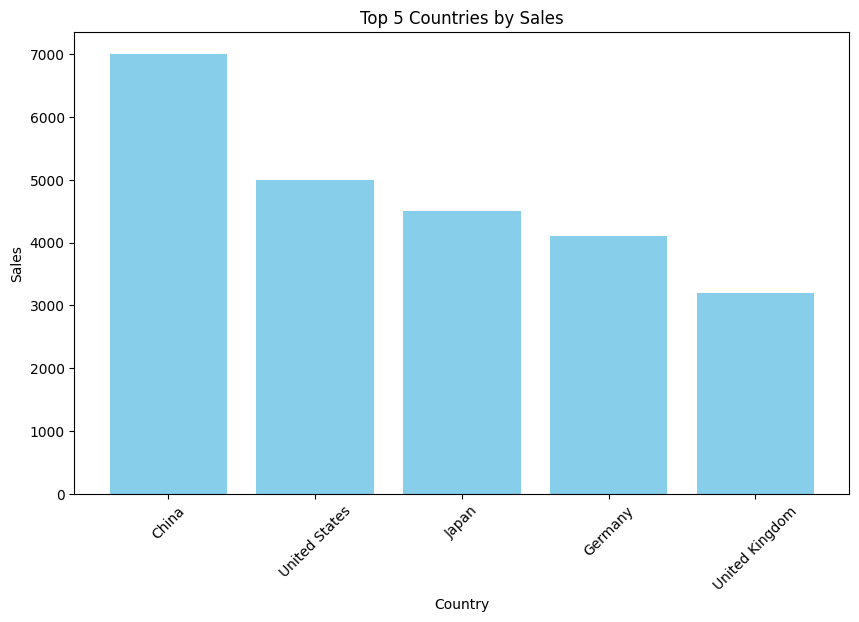

In [7]:
import os
from pandasai import Agent
import pandas as pd
from pandasai.llm import OpenAI


# Sample DataFrames
sales_by_country = pd.DataFrame({
    "country": ["United States", "United Kingdom", "France", "Germany", "Italy", "Spain", "Canada", "Australia", "Japan", "China"],
    "sales": [5000, 3200, 2900, 4100, 2300, 2100, 2500, 2600, 4500, 7000],
    "deals_opened": [142, 80, 70, 90, 60, 50, 40, 30, 110, 120],
    "deals_closed": [120, 70, 60, 80, 50, 40, 30, 20, 100, 110]
})

OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")

llm=OpenAI()


agent = Agent(sales_by_country, config={"llm": llm})

agent.chat('plot the top 5 countries by sales?')
# Output: China, United States, Japan, Germany, Australia


### Use smart dataframe

answer: e:/Github/procore_agent/exports/charts/temp_chart.png


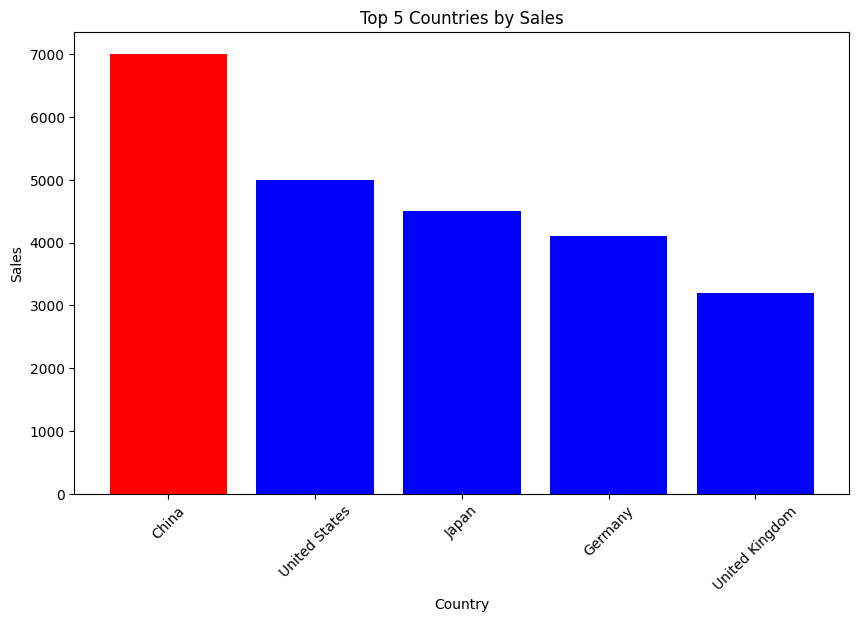

In [1]:
import os
import pandas as pd
from pandasai import SmartDataframe
from pandasai.llm import OpenAI

# Sample DataFrame
sales_by_country = pd.DataFrame({
    "country": ["United States", "United Kingdom", "France", "Germany", "Italy", "Spain", "Canada", "Australia", "Japan", "China"],
    "sales": [5000, 3200, 2900, 4100, 2300, 2100, 2500, 2600, 4500, 7000]
})

# By default, unless you choose a different LLM, it will use BambooLLM.
# You can get your free API key signing up at https://pandabi.ai (you can also configure it in your .env file)

OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")

llm = OpenAI()

df = SmartDataframe(sales_by_country, config={"llm": llm})
a= df.chat('Which are the top 5 countries by sales? and plot it color the top country red')
# Output: China, United States, Japan, Germany, Australia
print("answer:",a)


### pandas ai sql connector

answer: e:/Github/procore_agent/exports/charts/temp_chart.png


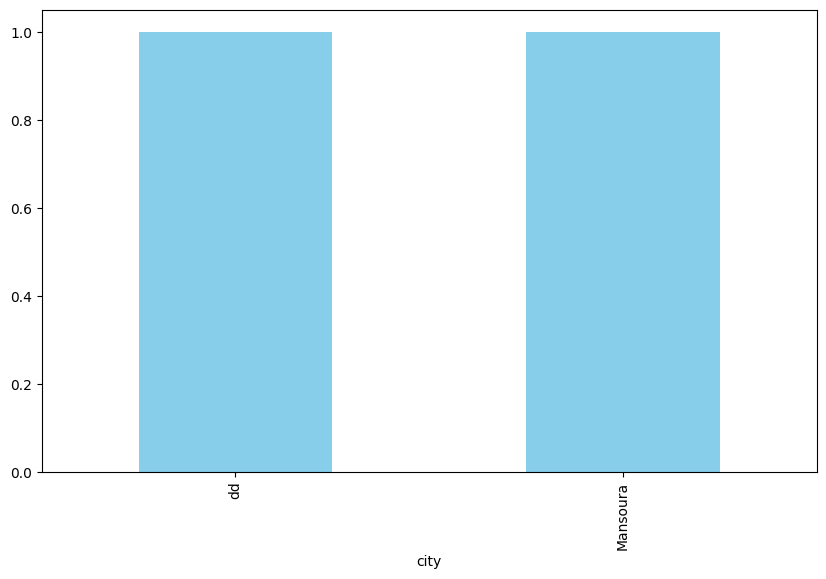

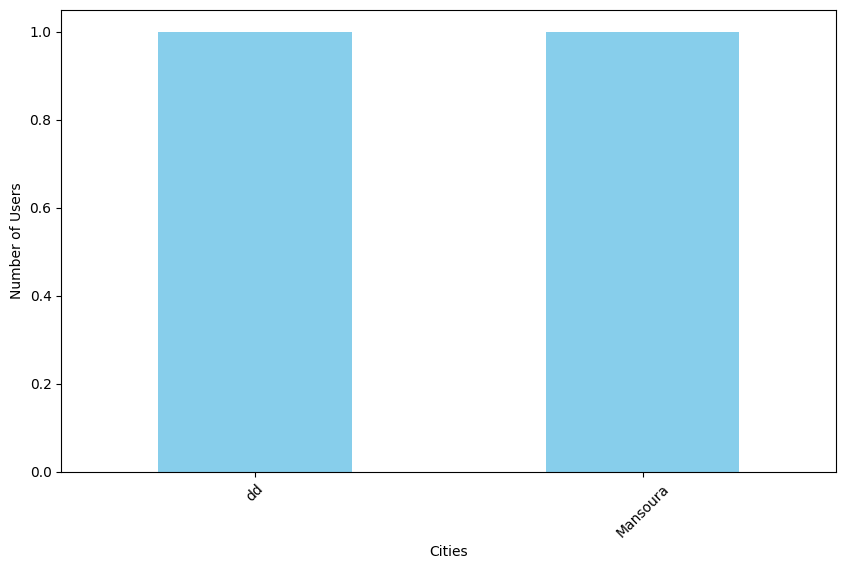

In [35]:
import os
import pandas as pd
import sqlite3
from pandasai import SmartDataframe
from pandasai.llm import OpenAI

# Get the absolute path to your SQLite database
sqlite_path = os.path.abspath("procore_db.sqlite")

# Connect to the SQLite database
conn = sqlite3.connect(sqlite_path)

# Read data from the 'users' table into a pandas DataFrame
dataframe = pd.read_sql_query("SELECT * FROM users", conn)

# Close the database connection
conn.close()

# Initialize the OpenAI LLM with your API key
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
llm = OpenAI(api_token=OPENAI_API_KEY)

# Create a SmartDataframe using the DataFrame and LLM
df = SmartDataframe(dataframe, config={"llm": llm})

# Use the chat function as intended
answer = df.chat('Please provide me with the users cities in graph.')
print("answer:", answer)

In [48]:
import os
import pandas as pd
import sqlite3
from pandasai import SmartDatalake, SmartDataframe
from pandasai.llm import OpenAI
from langfuse.callback import CallbackHandler


LANGFUSE_SECRET_KEY=os.getenv("LANGFUSE_SECRET_KEY")
LANGFUSE_PUBLIC_KEY=os.getenv("LANGFUSE_PUBLIC_KEY")
LANGFUSE_HOST=os.getenv("LANGFUSE_HOST")


# Define the langfuse handler (using environment variables for secret keys)
def get_langfuse_handler() -> CallbackHandler:
    secret_key = os.getenv("LANGFUSE_SECRET_KEY")
    public_key = os.getenv("LANGFUSE_PUBLIC_KEY")
    host = os.getenv("LANGFUSE_HOST")
    return CallbackHandler(secret_key=secret_key, public_key=public_key, host=host)

# Get the absolute path to your SQLite database
sqlite_path = os.path.abspath("procore_db.sqlite")

# Connect to the SQLite database
conn = sqlite3.connect(sqlite_path)


langfuse_handler = get_langfuse_handler()

# Read data from the 'users' table into a pandas DataFrame
users_df = pd.read_sql_query("SELECT * FROM users", conn)
filtered_users_df = pd.read_sql_query("SELECT * FROM filtered_users", conn)

# Close the database connection
conn.close()

# Initialize the OpenAI LLM with your API key
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
llm = OpenAI(api_token=OPENAI_API_KEY)

# Create a SmartDataframe using the DataFrame and LLM
df = SmartDatalake([users_df,filtered_users_df], config={"llm": llm, "CallbackHandler":[langfuse_handler]})

# Use the chat function as intended
answer = df.chat('Please provide graphical comparason between cont of users in both tables.')
print("answer:", answer)

answer: e:/Github/procore_agent/exports/charts/temp_chart.png


In [51]:
import os
import pandas as pd
import sqlite3
from pandasai import SmartDatalake, SmartDataframe
from pandasai.llm import OpenAI
from langfuse.callback import CallbackHandler
from langfuse import Langfuse
import logging

# Set up logging
# logging.basicConfig(level=logging.DEBUG)
# logger = logging.getLogger(__name__)

# Environment variables with validation
def get_required_env_var(var_name: str) -> str:
    value = os.getenv(var_name)
    if not value:
        raise ValueError(f"Missing required environment variable: {var_name}")
    return value

try:
    LANGFUSE_SECRET_KEY = get_required_env_var("LANGFUSE_SECRET_KEY")
    LANGFUSE_PUBLIC_KEY = get_required_env_var("LANGFUSE_PUBLIC_KEY")
    LANGFUSE_HOST = get_required_env_var("LANGFUSE_HOST")
    OPENAI_API_KEY = get_required_env_var("OPENAI_API_KEY")

    logger.debug("Environment variables loaded successfully")

    # Initialize Langfuse client
    langfuse = Langfuse(
        public_key=LANGFUSE_PUBLIC_KEY,
        secret_key=LANGFUSE_SECRET_KEY,
        host=LANGFUSE_HOST
    )
    logger.debug("Langfuse client initialized")

    # Define the langfuse handler with the client
    def get_langfuse_handler() -> CallbackHandler:
        handler = CallbackHandler(
            secret_key=LANGFUSE_SECRET_KEY,
            public_key=LANGFUSE_PUBLIC_KEY,
            host=LANGFUSE_HOST
        )
        logger.debug(f"Langfuse handler initialized with host: {handler.host}")
        return handler

    # Database operations
    sqlite_path = os.path.abspath("procore_db.sqlite")
    logger.debug(f"SQLite database path: {sqlite_path}")

    if not os.path.exists(sqlite_path):
        raise FileNotFoundError(f"Database file not found: {sqlite_path}")

    # Connect to the SQLite database
    conn = sqlite3.connect(sqlite_path)
    logger.debug("Database connection established")

    # Create Langfuse trace
    trace = langfuse.trace(
        name="pandas_ai_analysis",
        metadata={
            "database": sqlite_path,
            "timestamp": pd.Timestamp.now().isoformat()
        }
    )
    logger.debug(f"Langfuse trace created with ID: {trace.id}")

    langfuse_handler = get_langfuse_handler()

    # Read data from the tables into pandas DataFrames
    try:
        users_df = pd.read_sql_query("SELECT * FROM users", conn)
        filtered_users_df = pd.read_sql_query("SELECT * FROM filtered_users", conn)

        logger.debug(f"Users table shape: {users_df.shape}")
        logger.debug(f"Filtered users table shape: {filtered_users_df.shape}")

    except sqlite3.Error as e:
        logger.error(f"Database error: {e}")
        raise
    finally:
        conn.close()
        logger.debug("Database connection closed")

    # Initialize the OpenAI LLM with your API key
    llm = OpenAI(api_token=OPENAI_API_KEY)
    logger.debug("OpenAI LLM initialized")

    # Create a SmartDataframe using the DataFrame and LLM
    df = SmartDatalake(
        [users_df, filtered_users_df], 
        config={
            "llm": llm,
            "callbacks": [langfuse_handler],
            "trace_id": trace.id,
            "verbose": True  # Enable verbose mode for more debugging info
        }
    )
    logger.debug("SmartDatalake initialized")

    # Use the chat function within the trace context
    with trace.span(name="generate_comparison") as span:
        try:
            answer = df.chat('Please provide graphical comparison between count of users in both tables.')
            logger.info(f"Generated answer: {answer}")

            # Log success in span
            span.set_status("success")

        except Exception as e:
            logger.error(f"Error during chat: {e}")
            span.set_status("error")
            span.add_event("error", {"error": str(e)})
            raise
        finally:
            print("answer:", answer)

except Exception as e:
    logger.error(f"Application error: {e}")
    if 'trace' in locals():
        trace.set_status("error")
        trace.add_event("error", {"error": str(e)})
    raise

finally:
    # End the trace if it exists
    if 'trace' in locals():
        trace.end()
        logger.debug("Trace ended")

AttributeError: 'StatefulTraceClient' object has no attribute 'end'